# Wine Quality Classification Notebook

We will use concepts of machine learning and data mining to predict the quality of a wine sample.

The features we have in our dataset:

> 1- fixed acidity\
 2- volatile acidity\
3- citric acid\
4- residual sugar\
5- chlorides\
6- free sulfur dioxide\
7- total sulfur dioxide\
8- density\
9- pH\
10- alcohol\
11- type (white or red)\

Based on 11 features we will determine whether the wine quality is **_low, medium or high_**.

## Importing Packages

In [111]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler,LabelEncoder
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve, train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix as cm
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVR

import os
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

# Load Dataset

- Low quality wine is defined by quality score 5 or below

- Medium quality wine is defined by quality score between 6 and 8

- High quality wine is defined by quality score 8 or above

In [112]:
data = pd.read_csv('/home/louisedantas/code/LouiseDantas/winequalityN.csv')
quality_mapping={3 : 'low',4 : 'low',5: 'low',6 : 'medium',7: 'medium',8 : 'high',9 :'high'}
data['quality_bins']=data['quality'].map(quality_mapping)

# Checking if data is clean and Balanced

We will see below that theres a few wine occurences missing one or two features. We will delete these occurences without impact to the overall data since missing data is less than 0.5% of total data.

You will also see that the data is NOT well balanced.\
We have 93% medium quality wines\
        4% low quality\
        3% high quality

**a. Checking For _Duplicates_**

In [113]:
data[data.duplicated()]
duplicate_count=len(data[data.duplicated()])

In [114]:
data=data.drop_duplicates()

**b. Checking For _Missing Values_**

In [115]:
data.isnull().sum()/len(data)

type                    0.000000
fixed acidity           0.001877
volatile acidity        0.001501
citric acid             0.000563
residual sugar          0.000375
chlorides               0.000375
free sulfur dioxide     0.000000
total sulfur dioxide    0.000000
density                 0.000000
pH                      0.001689
sulphates               0.000751
alcohol                 0.000000
quality                 0.000000
quality_bins            0.000000
dtype: float64

In [116]:
data=data.dropna()

**c. Checking For _Outliers_**

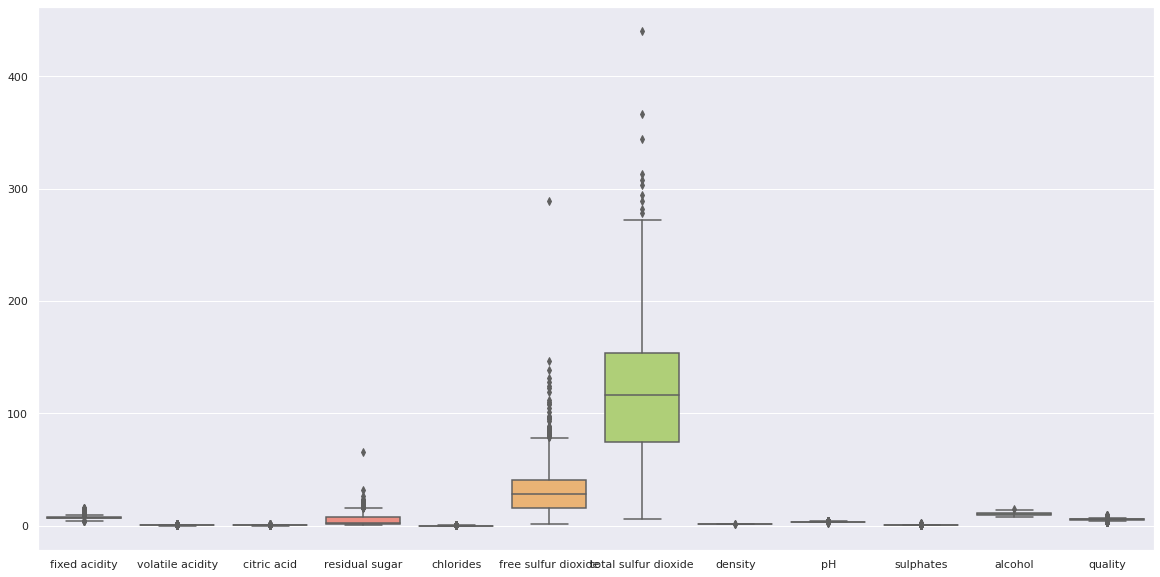

In [117]:
sns.set()
plt.figure(figsize=(20,10))
sns.boxplot(data=data,palette="Set3")
plt.show()

In [118]:
low_lim=data["free sulfur dioxide"].mean() - 3*data["free sulfur dioxide"].std()
upp_lim=data["free sulfur dioxide"].mean() + 3*data["free sulfur dioxide"].std()

data=data[(data["free sulfur dioxide"]>low_lim) &(data["free sulfur dioxide"]<upp_lim)].copy()

In [119]:
low_lim=data["total sulfur dioxide"].mean() - 3*data["total sulfur dioxide"].std()
upp_lim=data["total sulfur dioxide"].mean() + 3*data["total sulfur dioxide"].std()

data=data[(data["total sulfur dioxide"]>low_lim) &(data["total sulfur dioxide"]<upp_lim)].copy()

In [120]:
low_lim=data["residual sugar"].mean() - 3*data["residual sugar"].std()
upp_lim=data["residual sugar"].mean() + 3*data["residual sugar"].std()

data=data[(data["residual sugar"]>low_lim) &(data["residual sugar"]<upp_lim)].copy()

**d.Check Distribution of data by type to confirm balance among them**

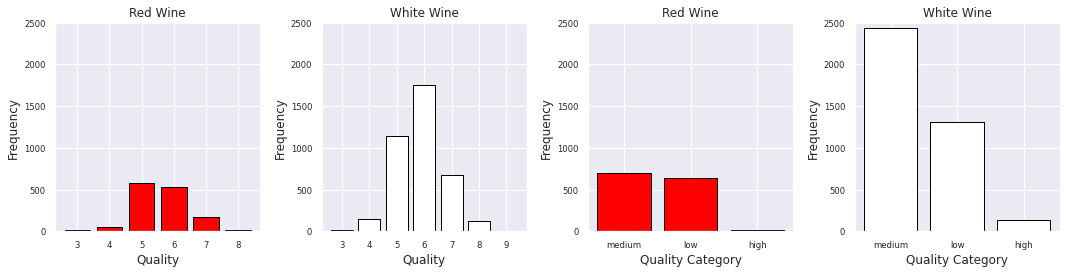

In [121]:
fig=plt.figure(figsize=(18,4))
fig.subplots_adjust(top=0.85,wspace=0.3)

ax1=fig.add_subplot(1,4,1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency")
red_summary=data[data['type']=='red']['quality'].value_counts()
red_summary=(list(red_summary.index),list(red_summary.values))
ax1.set_ylim([0,2500])
ax1.tick_params(axis='both',which='major',labelsize=8.5)
bar_1=ax1.bar(red_summary[0],red_summary[1],color='red',edgecolor='black', linewidth=1)

ax2=fig.add_subplot(1,4,2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency")
white_summary=data[data['type']=='white']['quality'].value_counts()
white_summary=(list(white_summary.index),list(white_summary.values))
ax2.set_ylim([0,2500])
ax2.tick_params(axis='both',which='major',labelsize=8.5)
bar_2=ax2.bar(white_summary[0],white_summary[1],color='white',edgecolor='black', linewidth=1)


ax3=fig.add_subplot(1,4,3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Category")
ax3.set_ylabel("Frequency")
red_summary=data[data['type']=='red']['quality_bins'].value_counts()
red_summary=(list(red_summary.index),list(red_summary.values))
ax3.set_ylim([0,2500])
ax3.tick_params(axis='both',which='major',labelsize=8.5)
bar_1=ax3.bar(red_summary[0],red_summary[1],color='red',edgecolor='black', linewidth=1)

ax4=fig.add_subplot(1,4,4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Category")
ax4.set_ylabel("Frequency")
white_summary=data[data['type']=='white']['quality_bins'].value_counts()
white_summary=(list(white_summary.index),list(white_summary.values))
ax4.set_ylim([0,2500])
ax4.tick_params(axis='both',which='major',labelsize=8.5)
bar_4=ax4.bar(white_summary[0],white_summary[1],color='white',edgecolor='black', linewidth=1)

# Exploratory Data Analysis

In [122]:
features=data.columns
rs=round(data.loc[data.type=='red',features].describe(),2)
ws=round(data.loc[data.type=='white',features].describe(),2)

pd.concat([rs,ws],axis=0,keys=['Red Wine Stats', 'White Wine Stats']).T

Red Wine Stats                                           \
                              count   mean    std   min    25%    50%    75%   
fixed acidity                1352.0   8.32   1.74  4.60   7.10   7.90   9.20   
volatile acidity             1352.0   0.53   0.18  0.12   0.39   0.52   0.64   
citric acid                  1352.0   0.27   0.20  0.00   0.10   0.26   0.43   
residual sugar               1352.0   2.52   1.35  0.90   1.90   2.20   2.60   
chlorides                    1352.0   0.09   0.05  0.01   0.07   0.08   0.09   
free sulfur dioxide          1352.0  15.84  10.41  1.00   7.00  14.00  21.00   
total sulfur dioxide         1352.0  46.64  32.79  6.00  22.00  38.00  63.00   
density                      1352.0   1.00   0.00  0.99   1.00   1.00   1.00   
pH                           1352.0   3.31   0.15  2.74   3.21   3.31   3.40   
sulphates                    1352.0   0.66   0.17  0.33   0.55   0.62   0.73   
alcohol                      1352.0  10.43   1.08  8.40   9.50  10.15  11.10   
quality                      1352.0   5.62   0.82  3.00   5.00   6.00   6.00   

                             White Wine Stats                               \
                         max            count    mean    std   min     25%   
fixed acidity          15.90           3869.0    6.84   0.87  3.80    6.30   
volatile acidity        1.58           3869.0    0.28   0.10  0.08    0.21   
citric acid             1.00           3869.0    0.33   0.12  0.00    0.27   
residual sugar         15.50           3869.0    5.75   4.55  0.60    1.60   
chlorides               0.61           3869.0    0.05   0.02  0.01    0.04   
free sulfur dioxide    72.00           3869.0   34.28  15.71  2.00   23.00   
total sulfur dioxide  278.00           3869.0  136.13  41.94  9.00  106.00   
density                 1.00           3869.0    0.99   0.00  0.99    0.99   
pH                      4.01           3869.0    3.20   0.15  2.72    3.10   
sulphates               2.00           3869.0    0.49   0.11  0.22    0.41   
alcohol                14.90           3869.0   10.60   1.22  8.00    9.50   
quality                 8.00           3869.0    5.86   0.89  3.00    5.00   

                                              
                         50%     75%     max  
fixed acidity           6.80    7.30   14.20  
volatile acidity        0.26    0.33    1.10  
citric acid             0.32    0.39    1.66  
residual sugar          4.60    8.70   18.50  
chlorides               0.04    0.05    0.35  
free sulfur dioxide    33.00   45.00   83.00  
total sulfur dioxide  132.00  165.00  282.00  
density                 0.99    1.00    1.00  
pH                      3.18    3.29    3.82  
sulphates               0.48    0.55    1.08  
alcohol                10.50   11.40   14.20  
quality                 6.00    6.00    9.00

In [123]:
low=round(data.loc[data.quality_bins=='low',features].describe(),2)
medium=round(data.loc[data.quality_bins=='medium',features].describe(),2)
high=round(data.loc[data.quality_bins=='high',features].describe(),2)

pd.concat([low,medium,high],axis=0,keys=['Low Qlty Wine', 'Medium Qlty Wine','High Qlty Wine']).T

Low Qlty Wine                                      \
                             count    mean    std   min    25%     50%   
fixed acidity               1942.0    7.34   1.29  4.20   6.50    7.10   
volatile acidity            1942.0    0.41   0.19  0.10   0.26    0.34   
citric acid                 1942.0    0.30   0.16  0.00   0.20    0.29   
residual sugar              1942.0    5.15   4.50  0.60   1.80    2.60   
chlorides                   1942.0    0.07   0.05  0.01   0.04    0.05   
free sulfur dioxide         1942.0   28.08  17.77  2.00  13.00   25.00   
total sulfur dioxide        1942.0  115.86  60.69  6.00  65.00  119.00   
density                     1942.0    1.00   0.00  0.99   0.99    1.00   
pH                          1942.0    3.22   0.16  2.74   3.11    3.20   
sulphates                   1942.0    0.53   0.15  0.25   0.44    0.50   
alcohol                     1942.0    9.92   0.85  8.00   9.30    9.70   
quality                     1942.0    4.87   0.37  3.00   5.00    5.00   

                                     Medium Qlty Wine          ...          \
                         75%     max            count    mean  ...     75%   
fixed acidity           7.90   15.90           3128.0    7.16  ...    7.60   
volatile acidity        0.53    1.58           3128.0    0.31  ...    0.36   
citric acid             0.40    1.00           3128.0    0.33  ...    0.39   
residual sugar          7.80   18.50           3128.0    4.77  ...    7.00   
chlorides               0.08    0.61           3128.0    0.05  ...    0.06   
free sulfur dioxide    40.88   83.00           3128.0   30.26  ...   40.00   
total sulfur dioxide  164.00  282.00           3128.0  111.24  ...  147.25   
density                 1.00    1.00           3128.0    0.99  ...    1.00   
pH                      3.32    3.90           3128.0    3.23  ...    3.33   
sulphates               0.58    2.00           3128.0    0.54  ...    0.62   
alcohol                10.40   14.90           3128.0   10.89  ...   11.80   
quality                 5.00    5.00           3128.0    6.27  ...    7.00   

                             High Qlty Wine                               \
                         max          count    mean    std    min    25%   
fixed acidity          15.60          151.0    6.85   1.20   3.90   6.20   
volatile acidity        1.04          151.0    0.30   0.12   0.12   0.23   
citric acid             1.66          151.0    0.34   0.11   0.03   0.29   
residual sugar         18.40          151.0    4.78   3.63   0.80   1.90   
chlorides               0.42          151.0    0.04   0.02   0.01   0.03   
free sulfur dioxide    83.00          151.0   32.23  14.55   3.00  23.50   
total sulfur dioxide  278.00          151.0  111.28  39.24  12.00  95.00   
density                 1.00          151.0    0.99   0.00   0.99   0.99   
pH                      4.01          151.0    3.24   0.16   2.88   3.14   
sulphates               1.95          151.0    0.51   0.17   0.25   0.38   
alcohol                14.20          151.0   11.93   1.08   8.50  11.20   
quality                 7.00          151.0    8.03   0.18   8.00   8.00   

                                              
                         50%     75%     max  
fixed acidity           6.80    7.30   12.60  
volatile acidity        0.28    0.36    0.85  
citric acid             0.33    0.38    0.74  
residual sugar          3.80    6.85   14.80  
chlorides               0.04    0.04    0.12  
free sulfur dioxide    31.00   40.50   81.00  
total sulfur dioxide  114.00  130.50  212.50  
density                 0.99    0.99    1.00  
pH                      3.24    3.35    3.72  
sulphates               0.48    0.62    1.10  
alcohol                12.20   12.70   14.00  
quality                 8.00    8.00    9.00  

[12 rows x 24 columns]

# Correlations based on wine types

In [124]:
red_data=data[data['type']=='red'].copy()
white_data=data[data['type']=='white'].copy()

<AxesSubplot:>

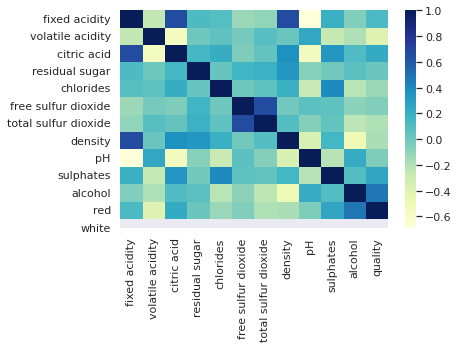

In [125]:
red_corr=red_data.corr()
#top_corr_cols=red_corr.color.sort_values(ascending=False).keys()

sns.heatmap(red_corr,xticklabels=red_corr.columns,
            yticklabels=corr.columns,
           cmap="YlGnBu")

In [126]:
red_corr_df=red_corr.unstack().reset_index()
red_corr_df.columns=['feature_1','feature_2', 'correlation']
red_corr_df = red_corr_df[red_corr_df['feature_1'] != red_corr_df['feature_2']]
red_corr_df.sort_values(by="correlation",ascending=False, inplace=True)
red_corr_df

,feature_1,feature_2,correlation
77,total sulfur dioxide,free sulfur dioxide,0.671312
66,free sulfur dioxide,total sulfur dioxide,0.671312
84,density,fixed acidity,0.670638
7,fixed acidity,density,0.670638
2,fixed acidity,citric acid,0.668047
...,...,...,...
98,pH,citric acid,-0.547580
25,citric acid,volatile acidity,-0.551685
14,volatile acidity,citric acid,-0.551685
8,fixed acidity,pH,-0.686803


<AxesSubplot:>

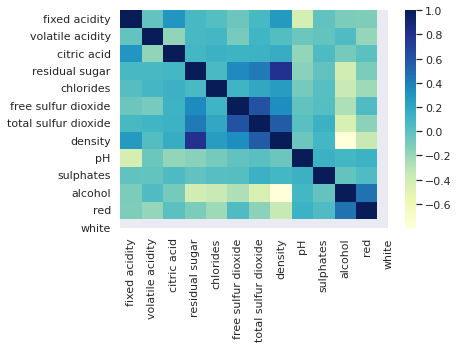

In [127]:
white_corr=white_data.corr()
#top_corr_cols=red_corr.color.sort_values(ascending=False).keys()

sns.heatmap(white_corr,xticklabels=corr.columns,
            yticklabels=corr.columns,
           cmap="YlGnBu")

In [128]:
white_corr_df=white_corr.unstack().reset_index()
white_corr_df.columns=['feature_1','feature_2', 'correlation']
white_corr_df = white_corr_df[white_corr_df['feature_1'] != white_corr_df['feature_2']]
white_corr_df.sort_values(by="correlation",ascending=False, inplace=True)
white_corr_df

,feature_1,feature_2,correlation
87,density,residual sugar,0.802292
43,residual sugar,density,0.802292
66,free sulfur dioxide,total sulfur dioxide,0.613594
77,total sulfur dioxide,free sulfur dioxide,0.613594
90,density,total sulfur dioxide,0.561792
...,...,...,...
8,fixed acidity,pH,-0.428938
82,total sulfur dioxide,alcohol,-0.453179
126,alcohol,total sulfur dioxide,-0.453179
94,density,alcohol,-0.797627


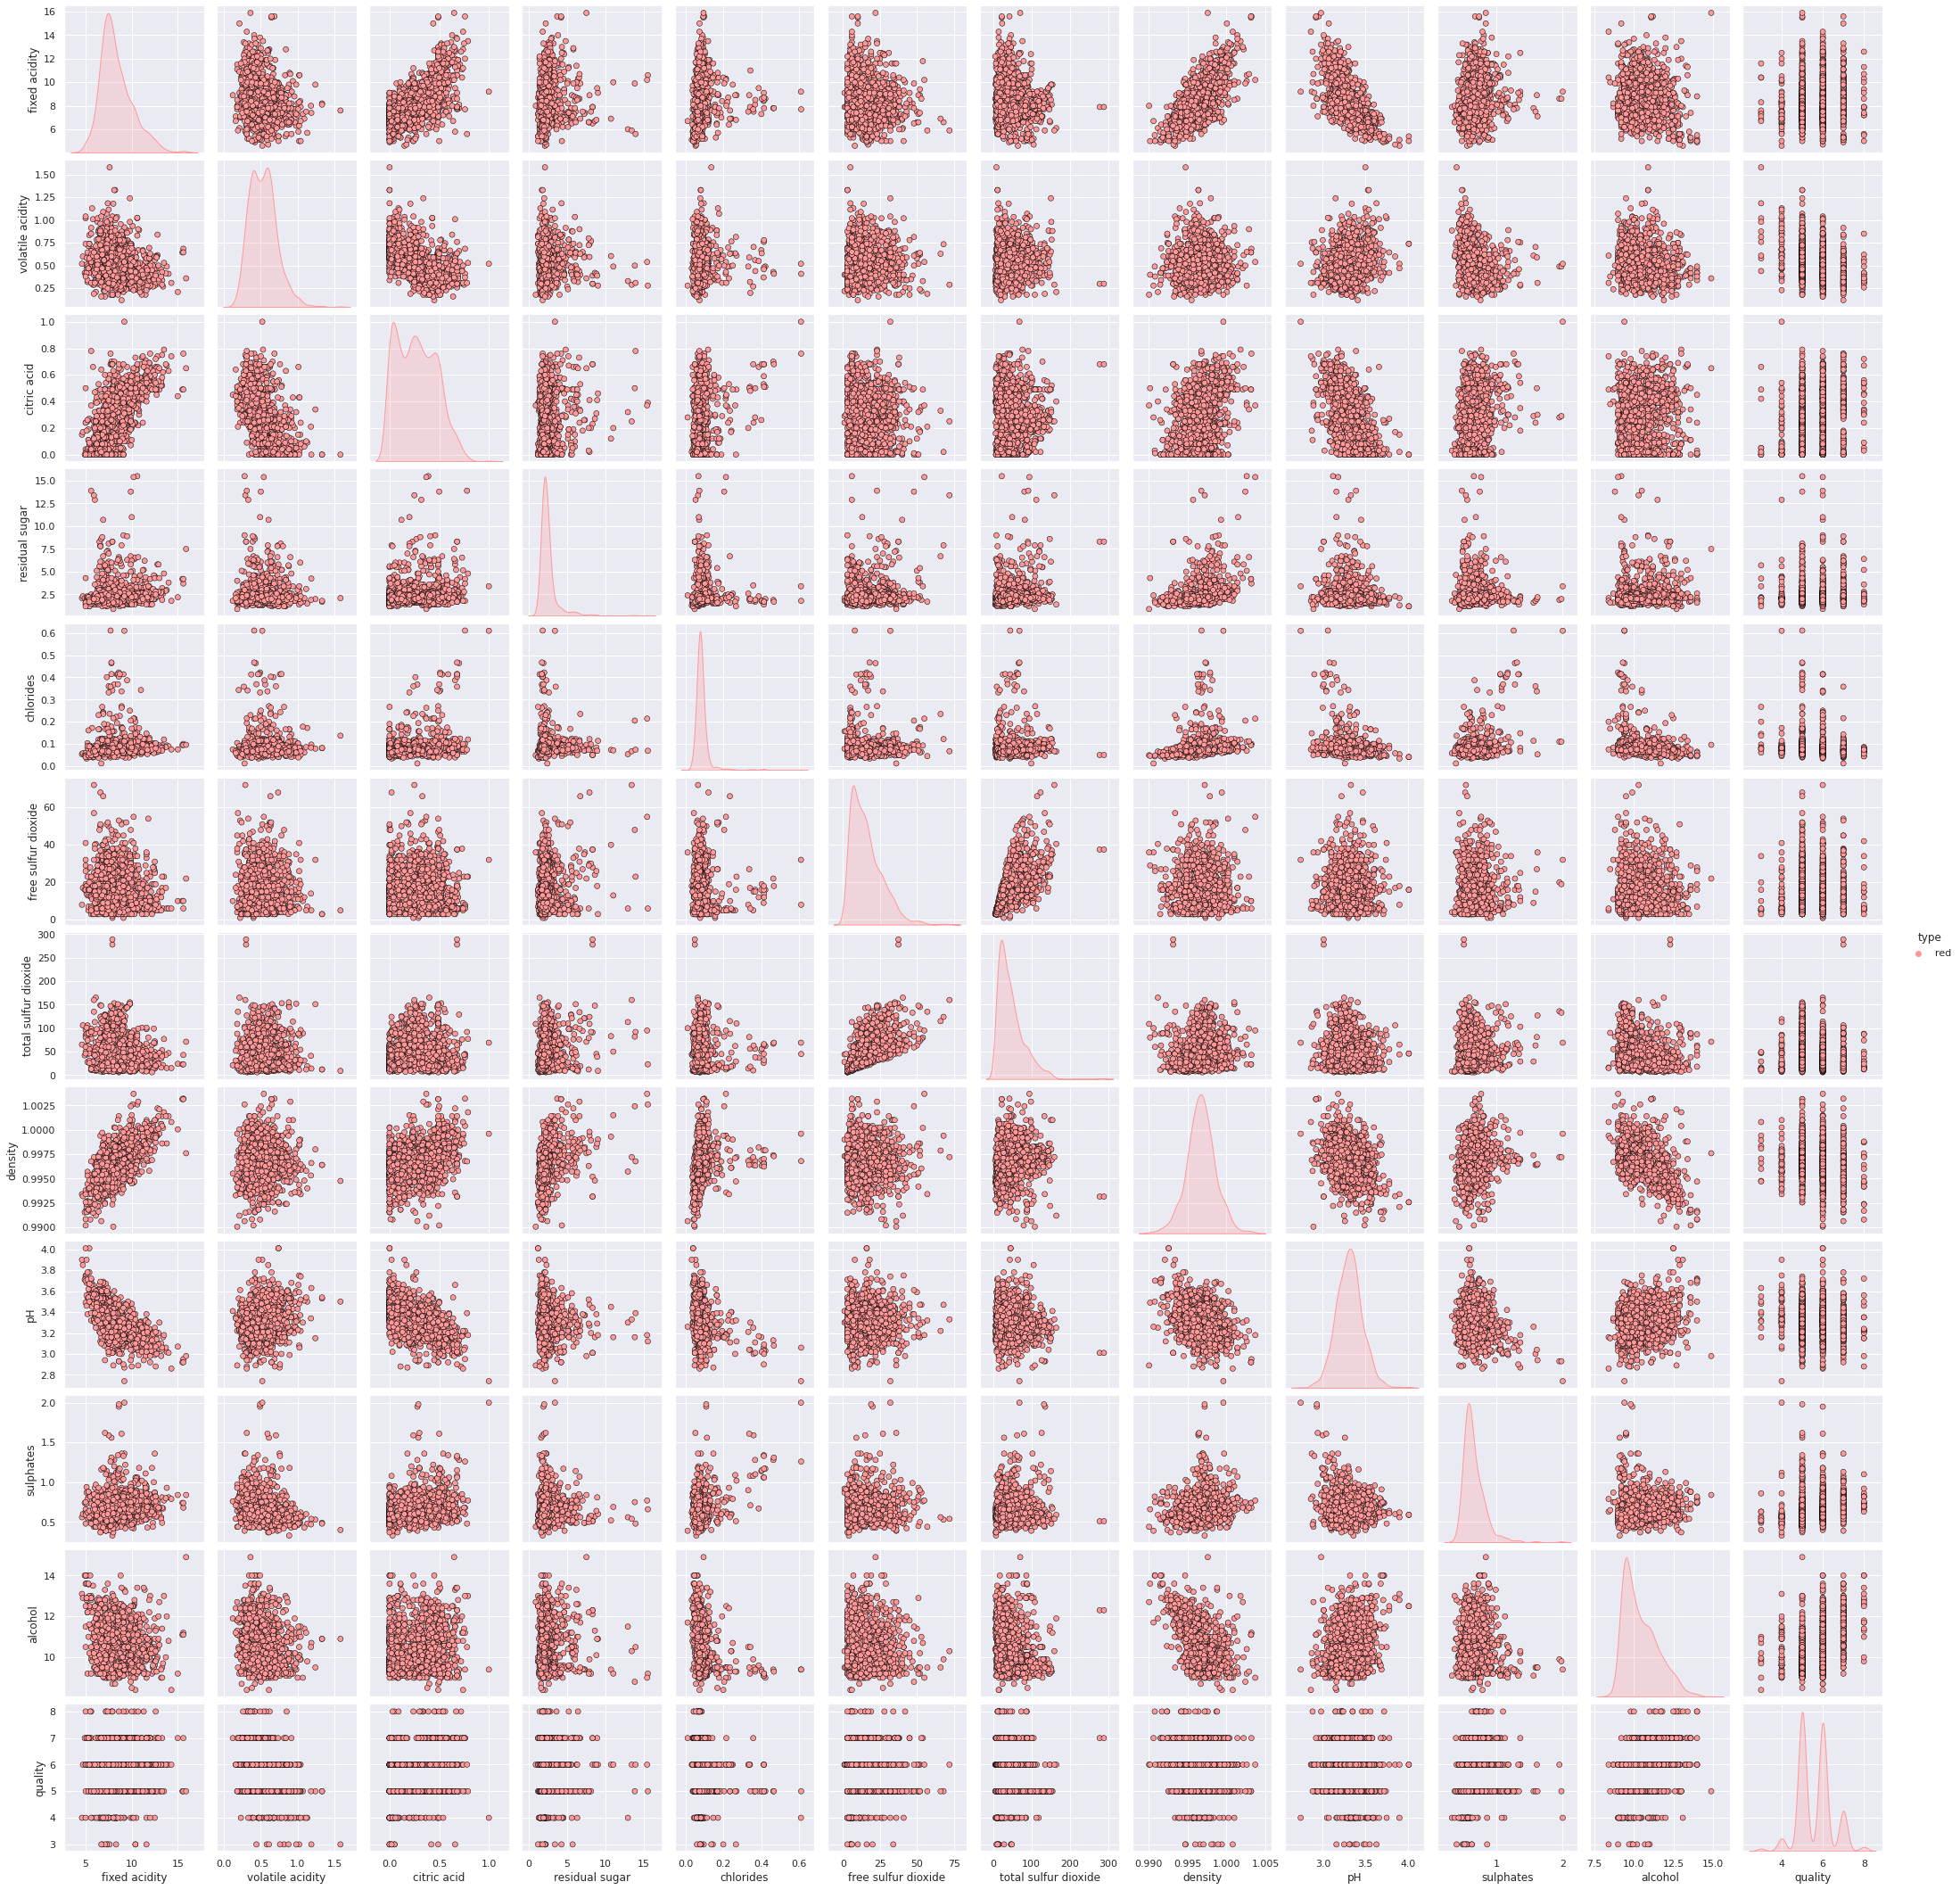

In [316]:
#sns.set(font_scale=1.0)
sns.pairplot(data = red_data, hue='type', palette={'red': '#FF9999', 'white': '#FFE888'},plot_kws=dict(edgecolor='black', linewidth=0.5))
#fig = g.fig 
#fig.subplots_adjust(top=0.96, wspace=0.2)
#t = fig.suptitle('Wine Attributes Pairwise Plots by Types', fontsize=24)

# Scaling

Scale numeric features

In [129]:
std_scaler = StandardScaler()
minmaxscaler = MinMaxScaler()

In [130]:
data.loc[:,data.columns[~data.columns.isin(['type','quality_bins'])]]=minmaxscaler.fit_transform(data.loc[:,data.columns[~data.columns.isin(['type','quality_bins'])]])

Scale categorical features

In [131]:
cat_scaler = OneHotEncoder(sparse=False)

In [132]:
cat_scaler.fit(data[['type']])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [133]:
type_encoded=cat_scaler.transform(data[['type']])

In [134]:
data['red'],data['white']=type_encoded.T

In [135]:
data=data.drop(['type','quality'],axis=1)

# Investigate Collinearity

<AxesSubplot:>

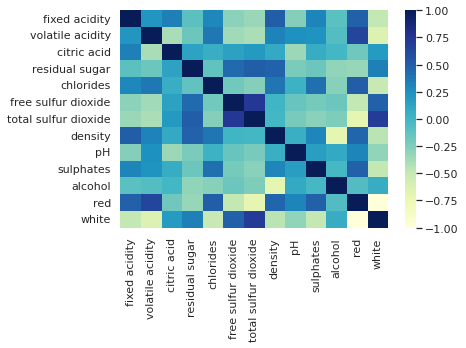

In [136]:
corr = data.corr()

sns.heatmap(corr,xticklabels=corr.columns,
            yticklabels=corr.columns,
           cmap="YlGnBu")

In [137]:
corr_df=corr.unstack().reset_index()
corr_df.columns=['feature_1','feature_2', 'correlation']
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']]
corr_df.sort_values(by="correlation",ascending=False, inplace=True)
corr_df

,feature_1,feature_2,correlation
83,total sulfur dioxide,free sulfur dioxide,0.727976
71,free sulfur dioxide,total sulfur dioxide,0.727976
90,total sulfur dioxide,white,0.702012
162,white,total sulfur dioxide,0.702012
144,red,volatile acidity,0.646975
...,...,...,...
137,alcohol,density,-0.687850
149,red,total sulfur dioxide,-0.702012
89,total sulfur dioxide,red,-0.702012
155,red,white,-1.000000


# Modeling - Grid Search

We used Grid Search method to scan through 6 models:

>- SVM
>- Decision Tree
>- Random Forest
>- Naive Bayes
>- Logistic Regression
>- KNN

If we analyze the accuracy results and confusion matrix we see that **Decision Tree** has the best compromise between accuracy and generalization.

The model works best if the purpose of the customer is to identify low quality wines and the customer accepts false-high quality or false-medium quality classification.

Decision Tree identifies 70% of the low quality wines. Preventing the wine store from ordering them.

In order to improve the results of the model we would need more features such as wine grapes and wine price.

Looking at the learning curves its clear we need more data. Specially high quality wines so we can train with balanced dataset.


In [138]:
X=data.drop(columns='quality_bins')
y=data[['quality_bins']]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [139]:
model_params  = {
    "svm" : {
        "model":SVC(gamma="auto"),
        "params":{
            'C' : [1,10,20],
            'kernel':["rbf"]
        }
    },
    
    "decision_tree":{
        "model": DecisionTreeClassifier(),
        "params":{
            'criterion':["entropy","gini"],
            "max_depth":[5,8,9]
        }
    },
    
    "random_forest":{
        "model": RandomForestClassifier(),
        "params":{
            "n_estimators":[1,5,10],
            "max_depth":[5,8,9]
        }
    },
    "naive_bayes":{
        "model": GaussianNB(),
        "params":{}
    },
    
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear',multi_class = 'auto'),
        'params': {
            "C" : [1,5,10]
        }
    },
        
    'KNN_classifier' : {
        'model' : KNeighborsClassifier(),
        'params': {
            "n_neighbors": [10, 11, 12, 13]
        }
    }
    
}

In [140]:
score=[]
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp["model"],mp["params"],cv=8,return_train_score=False)
    clf.fit(X,y)
    score.append({
        "Model" : model_name,
        "Best_Score": clf.best_score_,
        "Best_Params": clf.best_params_
    })

In [141]:
pd.DataFrame(score,columns=["Model","Best_Score","Best_Params"])

,Model,Best_Score,Best_Params
0,svm,0.704662,"{'C': 20, 'kernel': 'rbf'}"
1,decision_tree,0.699487,"{'criterion': 'entropy', 'max_depth': 5}"
2,random_forest,0.709255,"{'max_depth': 8, 'n_estimators': 10}"
3,naive_bayes,0.512929,{}
4,logistic_regression,0.709451,{'C': 10}
5,KNN_classifier,0.689335,{'n_neighbors': 13}


###  KNN

In [142]:
knn_model=KNeighborsClassifier(n_neighbors = 13)
knn_model.fit(X_train,y_train)

train_accuracy = knn_model.score(X_train, y_train)
test_accuracy = knn_model.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy Score of Train Model : {:.2f}'.format(train_accuracy), 
      'Accuracy Score of Test  Model : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy Score of Train Model : 0.75
Accuracy Score of Test  Model : 0.70


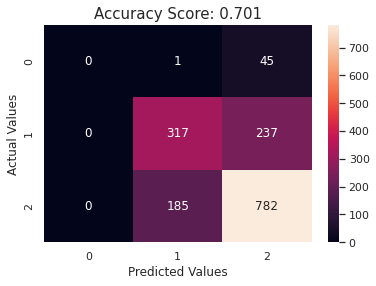

In [143]:
predictions = knn_model.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

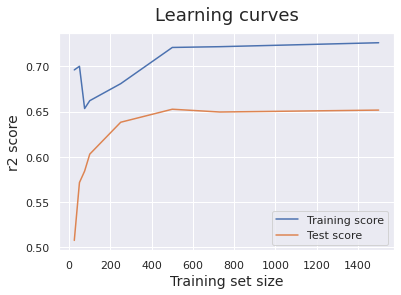

In [144]:
train_sizes, train_scores, test_scores = learning_curve(estimator = knn_model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [25,50,75,100,250,500,730,1500], 
                                                              cv = 5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend();

### Logistic Regression

In [145]:
log_model=LogisticRegression(max_iter=1000,random_state=40,C=5)
log_model.fit(X_train,y_train)

train_accuracy = log_model.score(X_train, y_train)
test_accuracy = log_model.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy Score of Train Model : {:.2f}'.format(train_accuracy), 
      'Accuracy Score of Test  Model : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy Score of Train Model : 0.72
Accuracy Score of Test  Model : 0.72


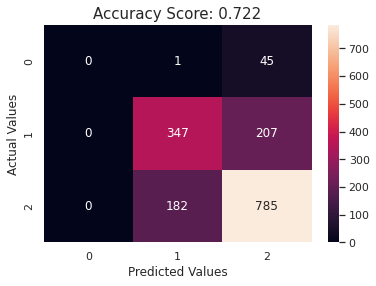

In [146]:
predictions = log_model.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

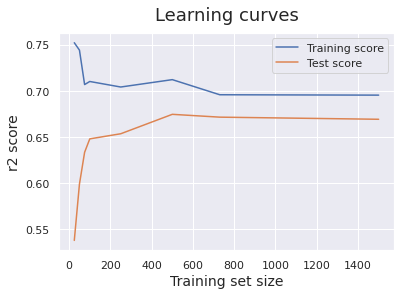

In [147]:
train_sizes, train_scores, test_scores = learning_curve(estimator =log_model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [25,50,75,100,250,500,730,1500], 
                                                              cv = 5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend();

### Random Forest

In [148]:
rdforest_model=RandomForestClassifier(max_depth=5,n_estimators=10)
rdforest_model.fit(X_train,y_train)

train_accuracy = rdforest_model.score(X_train, y_train)
test_accuracy = rdforest_model.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy Score of Train Model : {:.2f}'.format(train_accuracy), 
      'Accuracy Score of Test  Model : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy Score of Train Model : 0.75
Accuracy Score of Test  Model : 0.72


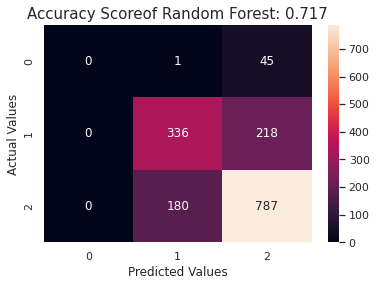

In [149]:
predictions = rdforest_model.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Scoreof Random Forest: {0}'.format(score), size = 15)
plt.show()

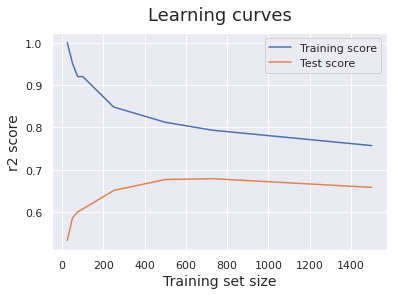

In [150]:
train_sizes, train_scores, test_scores = learning_curve(estimator =rdforest_model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [25,50,75,100,250,500,730,1500], 
                                                              cv = 5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend();

### SVM

In [151]:
svc_model=SVC(gamma="auto",C=1,kernel='rbf')
svc_model.fit(X_train,y_train)

train_accuracy = svc_model.score(X_train, y_train)
test_accuracy = svc_model.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy Score of Train Model : {:.2f}'.format(train_accuracy), 
      'Accuracy Score of Test  Model : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy Score of Train Model : 0.71
Accuracy Score of Test  Model : 0.72


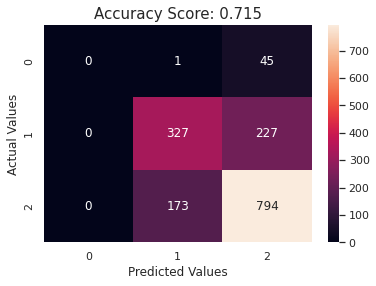

In [152]:
predictions = svc_model.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

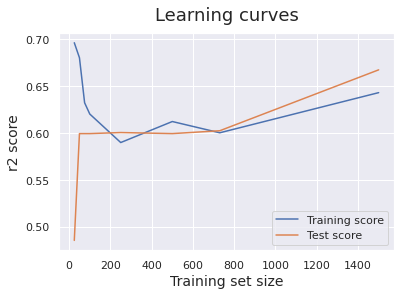

In [153]:
train_sizes, train_scores, test_scores = learning_curve(estimator =svc_model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [25,50,75,100,250,500,730,1500], 
                                                              cv = 5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend();

### Decision Tree

In [154]:
dectree_model=DecisionTreeClassifier(criterion='entropy', max_depth=5)
dectree_model.fit(X_train,y_train)

train_accuracy = dectree_model.score(X_train, y_train)
test_accuracy = dectree_model.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy Score of Train Model : {:.2f}'.format(train_accuracy), 
      'Accuracy Score of Test  Model : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy Score of Train Model : 0.74
Accuracy Score of Test  Model : 0.68


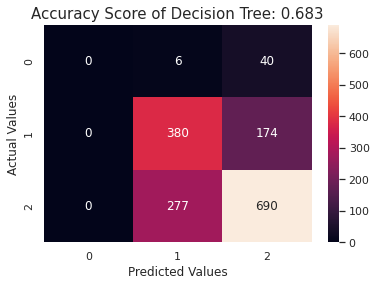

In [155]:
predictions = dectree_model.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score of Decision Tree: {0}'.format(score), size = 15)
plt.show()

### GaussianNB

In [156]:
nb_model=GaussianNB()
nb_model.fit(X_train,y_train)

train_accuracy = nb_model.score(X_train, y_train)
test_accuracy = nb_model.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy Score of Train Model : {:.2f}'.format(train_accuracy), 
      'Accuracy Score of Test  Model : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy Score of Train Model : 0.57
Accuracy Score of Test  Model : 0.56


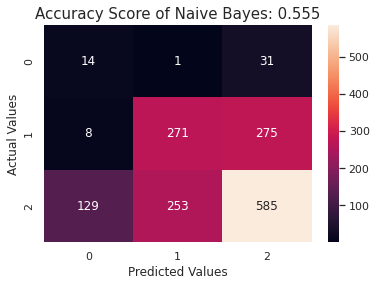

In [157]:
predictions = nb_model.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score of Naive Bayes: {0}'.format(score), size = 15)
plt.show()

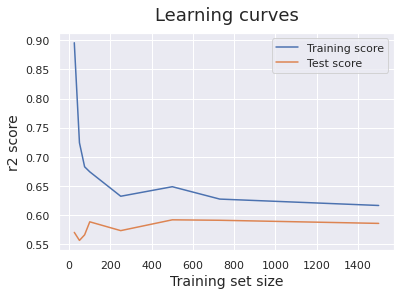

In [158]:
train_sizes, train_scores, test_scores = learning_curve(estimator =nb_model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [25,50,75,100,250,500,730,1500], 
                                                              cv = 5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend();